# Using HOLE in MDAnalysis with order parameters

The [MDAnalysis.analysis.hole](http://www.mdanalysis.org/mdanalysis/documentation_pages/analysis/hole.html) module in [MDAnalysis](http://mdanalysis.org) can analyze trajectories of, say ion channels, and associate the per-frame pore radius profiles $R_\rho(\zeta)$ with an order parameter $\rho$ for each frame of the trajectory.

In this example notebook we use a synthetic and short trajectory of the gramicidin A cation pore (gA). The trajectory was generated from the first elastic network mode of gA, generated by the [elNémo](http://www.sciences.univ-nantes.fr/elnemo/) server, using the gA structure [1GRM](http://dx.doi.org/10.2210/pdb1grm/pdb). (The trajectory is included as a test case trajectory `MULTIPDB_HOLE` with the MDAnalysis unit tests and the X-ray structure is included as `PDB_HOLE`.)


## Load packages 

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis.hole import HOLEtraj
from MDAnalysis.analysis.rms import RMSD

from MDAnalysis.tests.datafiles import PDB_HOLE, MULTIPDB_HOLE
   
mda.start_logging()

MDAnalysis  : INFO     MDAnalysis 0.15.1-dev0 STARTED logging to 'MDAnalysis.log'
INFO:MDAnalysis:MDAnalysis 0.15.1-dev0 STARTED logging to 'MDAnalysis.log'


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## System set up
We take the X-ray structure as the reference and we want to analyze the ENM-mode trajectory so we load them into two separate universes:

In [3]:
ref = mda.Universe(PDB_HOLE)    # reference structure
u = mda.Universe(MULTIPDB_HOLE) # trajectory

DEBUG:MDAnalysis.core.AtomGroup:Universe.load_new(): loading /Volumes/Data/oliver/Biop/Library/python/mdanalysis/testsuite/MDAnalysisTests/data/1grm_single.pdb...
DEBUG:MDAnalysis.core.AtomGroup:Universe.load_new(): loading /Volumes/Data/oliver/Biop/Library/python/mdanalysis/testsuite/MDAnalysisTests/data/1grm_elNemo_mode7.pdb.bz2...


## Order parameter calculation
We calculate the all-atom RMSD from the reference structure as the order parameter $\rho$:

In [4]:
# calculate RMSD
R = RMSD(u, reference=ref, select="protein", mass_weighted=True)
R.run()

MDAnalysis.analysis.rmsd: INFO     RMS calculation for 260 atoms.
INFO:MDAnalysis.analysis.rmsd:RMS calculation for 260 atoms.
/Volumes/Data/oliver/Biop/Library/python/mdanalysis/package/MDAnalysis/coordinates/base.py:733: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")
RMSD  6.11 A at frame    11/11  [100.0%]


The timeseries of the orderparameter is `R.rmsd` (an N x 3 array, with each row `(frame, time, RMSD)`):

In [5]:
frame, _, rho = R.rmsd.transpose()

For the trajectory from the ENM, time is meaningless so we just plot over frame number.

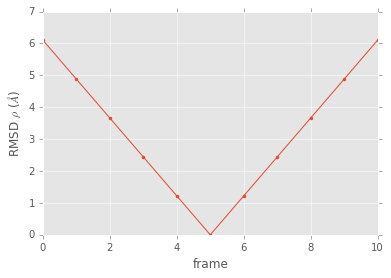

In [6]:
ax = plt.subplot(111)
ax.plot(frame, rho, '.-')
ax.set_xlabel("frame")
ax.set_ylabel(r"RMSD $\rho$ ($\AA$)");

Note that the ENM trajectory is symmetric to frame 5 (the original X-ray structure) and the mode deforms the structure so that the RMSD increases nearly linearly.

## HOLE
Run [HOLE](http://www.smartsci.uk/hole/) on all 11 frames of the trajectory in universe `u` and match the frames to the RMSD:

In [8]:
# HOLE analysis with order parameters
H = HOLEtraj(u, orderparameters=R.rmsd[:,2], 
             executable="~/hole2/exe/hole")
H.run()

MDAnalysis.analysis.hole: INFO     HOLE analysis frame    0 (orderparameter 6.10501)
INFO:MDAnalysis.analysis.hole:HOLE analysis frame    0 (orderparameter 6.10501)
DEBUG:MDAnalysis.analysis.hole:path check: HOLE will not read '/Volumes/Data/oliver/Biop/Projects/Methods/MDAnalysis/notebooks/hole-orderparameters/simple2.rad' because it has more than 70 characters.
DEBUG:MDAnalysis.analysis.hole:path check: Using relative path: '/Volumes/Data/oliver/Biop/Projects/Methods/MDAnalysis/notebooks/hole-orderparameters/simple2.rad' --> 'simple2.rad'
MDAnalysis.analysis.hole: INFO     Setting up HOLE analysis for '/var/folders/qs/k07z49fh8xl6xd008k8wxhxr0000gp/T/tmpaVfgsb.pdb'
INFO:MDAnalysis.analysis.hole:Setting up HOLE analysis for '/var/folders/qs/k07z49fh8xl6xd008k8wxhxr0000gp/T/tmpaVfgsb.pdb'
MDAnalysis.analysis.hole: INFO     Using radius file 'simple2.rad'
INFO:MDAnalysis.analysis.hole:Using radius file 'simple2.rad'
MDAnalysis.analysis.hole: INFO     HOLE will guess CPOINT
INFO:MDAnalys

### Visualization of pore profiles 

As a quick check, plot the pore profiles $R_\rho(\zeta)$:

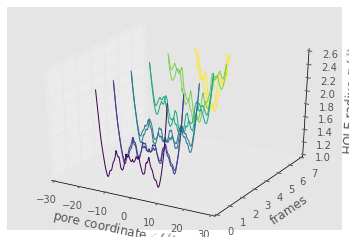

In [9]:
H.plot3D(rmax=2.5)

The 2D plot clearly shows how the pore profile opens up with increasing order parameter (i.e., increasing strength of the deformation along the mode):

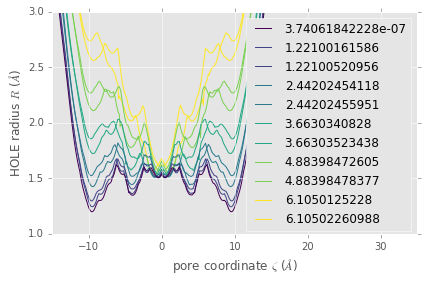

In [10]:
ax = H.plot()
ax.set_ylim(1, 3)
ax.set_xlim(-15, 35)
plt.tight_layout()

### Analysis of the minimum pore radius
Is the motion one that could possibly gate the pore, i.e., change the pore radius to a radius that makes more ions pass through? (Note: gA is already open so scientifically this is not a great question...)

We collect the minimum pore radius from each profile 

$$
r(\rho) = \min_\zeta R_\rho(\zeta)
$$

and store it together with the corresponding order parameter:

In [11]:
r_rho = np.array([[rho, profile.radius.min()] for rho, profile in H])

The plot shows quantitatively that the pore opens up. 

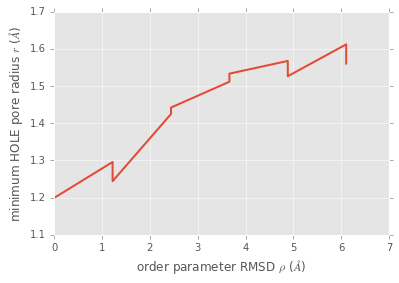

In [12]:
ax = plt.subplot(111)
ax.plot(r_rho[:, 0], r_rho[:, 1], lw=2)
ax.set_xlabel(r"order parameter RMSD $\rho$ ($\AA$)")
ax.set_ylabel(r"minimum HOLE pore radius $r$ ($\AA$)");

Comparison to the stacked pore profile plots it is clear that the constriction itself changes position. We can calculate the constriction point along the pore axis
$$
\zeta_0(\rho) = \text{arg} \min_\zeta R_\rho(\zeta)
$$

In [13]:
zeta0_rho = np.array([[rho, profile.rxncoord[np.argmin(profile.radius)]] 
                      for rho, profile in H])

The plot clearly shows that for $\rho < 2.5$ A, the constriction is near the end but for larger distortions it is close to the center of the pore.

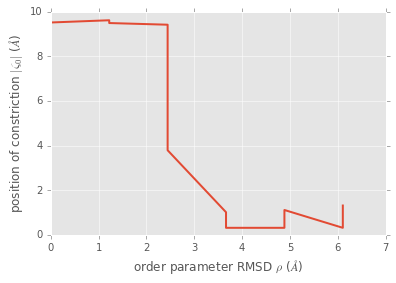

In [14]:
ax = plt.subplot(111)
ax.plot(zeta0_rho[:, 0], np.abs(zeta0_rho[:, 1]), lw=2)
ax.set_xlabel(r"order parameter RMSD $\rho$ ($\AA$)")
ax.set_ylabel(r"position of constriction $|\zeta_0|$ ($\AA$)");

(For the plot I symmetrized $\zeta_0$ using `np.abs(zeta0)` because for small $\rho$, either of the two constriction sites near the ends is closed. However, the HOLE search procedure will typically not exactly reproduce the symmetry. For real work one might want to average over the two lowest values near the inside and the outside.)

## See Also
* [MDAnalysis.analysis.hole](http://pythonhosted.org/MDAnalysis/documentation_pages/analysis/hole.html) documentation
* notebook [MDAnalysis HOLE Basics](http://nbviewer.jupyter.org/gist/orbeckst/64c0bd5a037b3e434cc8ee6732030252)